In [ ]:
# NOTE some of this code is old as it was the early notebooks working with ACCESS data
# Needs to be updated to use functions etc.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors

In [2]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [3]:
# Global stuff 

# Year range 
years = range(1981, 2019)

# Define the base dates for sep, oct, and nov with lag 9
base_dates = ['0121', '0124', '0125', '0126', '0127', '0128', '0129', '0130', '0131',
              '0216', '0221', '0222', '0223', '0224', '0225', '0226', '0227', '0228',
              '0321', '0324', '0325', '0326', '0327', '0328', '0329', '0330', '0331']

# Function to load first timestep and retain its time coordinate
def load_first_timestep(file_path):
    with xr.open_dataset(file_path) as ds:
        ds = ds.isel(time=0).load()  # Load only first timestep
        ds = ds.assign_coords(time=[ds.time.values])  # Keep original time coordinate
    return ds

# Function to load last timestep and retain its time coordinate
def load_last_timestep(file_path):
    with xr.open_dataset(file_path) as ds:
        ds = ds.isel(time=-1).load()  # Load only last timestep
        ds = ds.assign_coords(time=[ds.time.values])  # Keep original time coordinate
    return ds

def reshape_to_ensemble(ds):
    # Ensure the dataset has 9 ensemble members and 3 months per year
    ds = ds.assign_coords(ensemble=("time", np.tile(np.arange(9), len(ds.time) // 9)))
    
    # Reshape time -> (year, ensemble, month)
    ds = ds.groupby("ensemble").map(lambda x: x.coarsen(time=3, boundary="trim").mean())
    
    return ds.swap_dims({"time": "ensemble"}).drop_vars("time")

In [4]:
# Define the file pattern
file_pattern = "/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc"

# Generate file paths for each year from 1981 to 2018
file_paths = [file_pattern.format(f"{year}{date}") for year in years for date in base_dates]

# Load datasets with correct time from each file
datasets = [load_last_timestep(file) for file in file_paths]

# Concatenate along the time axis
ds_final = xr.concat(datasets, dim="time").pr

# Extract years from the time coordinate
ds_grouped = ds_final.groupby("time.year")

# Apply function to each year separately
ds_ensemble1 = ds_grouped.map(reshape_to_ensemble)

In [5]:
# Define the file pattern
file_pattern = "/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc"

# Generate file paths for each year from 1981 to 2018
file_paths = [file_pattern.format(f"{year}{date}") for year in years for date in base_dates]

# Load datasets with correct time from each file
datasets = [load_last_timestep(file) for file in file_paths]

# Concatenate along the time axis
ds_final = xr.concat(datasets, dim="time").pr

# Extract years from the time coordinate
ds_grouped = ds_final.groupby("time.year")

# Apply function to each year separately
ds_ensemble2 = ds_grouped.map(reshape_to_ensemble)

In [6]:
# Define the file pattern
file_pattern = "/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc"

# Generate file paths for each year from 1981 to 2018
file_paths = [file_pattern.format(f"{year}{date}") for year in years for date in base_dates]

# Load datasets with correct time from each file
datasets = [load_last_timestep(file) for file in file_paths]

# Concatenate along the time axis
ds_final = xr.concat(datasets, dim="time").pr

# Extract years from the time coordinate
ds_grouped = ds_final.groupby("time.year")

# Apply function to each year separately
ds_ensemble3 = ds_grouped.map(reshape_to_ensemble)

In [7]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

In [8]:
# Convert to mm per month and chunk 
son_lag9_yearly = (ds_combined * 30.33).chunk('auto')

#### ENSO composites with lag 9

In [9]:
# ENSO years
EN = [1963, 1965, 1968, 1969, 1972, 1976, 1977, 1979, 1982, 1986, 1987, 1991, 1994, 1997, 2002, 
      2004, 2006, 2009, 2014, 2015, 2018]

LN = [1964, 1966, 1967, 1970, 1971, 1973, 1974, 1975, 1983, 1984, 1988, 1995, 1996, 1998, 1999, 
      2000, 2005, 2007, 2010, 2011, 2017, 2020, 2021, 2022]

NN = [1960, 1961, 1962, 1978, 1980, 1981, 1985, 1989, 1990, 1992, 1993, 2001, 2003, 2008, 2012, 
      2013, 2016, 2019]

In [10]:
# Anomalies 
clim = son_lag9_yearly.mean(dim='year')
anom_son_lag9 = son_lag9_yearly - clim

# Anomalies in ENSO years
anom_son_lag9_EN = anom_son_lag9.sel(year=anom_son_lag9['year'].isin(EN))
anom_son_lag9_LN = anom_son_lag9.sel(year=anom_son_lag9['year'].isin(LN))
anom_son_lag9_NN = anom_son_lag9.sel(year=anom_son_lag9['year'].isin(NN))

# Composites 
comp_son_lag9_EN = anom_son_lag9_EN.mean(dim='year')
comp_son_lag9_LN = anom_son_lag9_LN.mean(dim='year')
comp_son_lag9_NN = anom_son_lag9_NN.mean(dim='year')

# Standrd deviation through time
comp_son_lag9_EN_std_time = anom_son_lag9_EN.std(dim='year').mean(dim='ensemble')
comp_son_lag9_LN_std_time = anom_son_lag9_LN.std(dim='year').mean(dim='ensemble')
comp_son_lag9_NN_std_time = anom_son_lag9_NN.std(dim='year').mean(dim='ensemble')

# Standrd deviation through ensemble
comp_son_lag9_EN_std_ens = anom_son_lag9_EN.std(dim='ensemble').mean(dim='year')
comp_son_lag9_LN_std_ens = anom_son_lag9_LN.std(dim='ensemble').mean(dim='year')
comp_son_lag9_NN_std_ens = anom_son_lag9_NN.std(dim='ensemble').mean(dim='year')

In [11]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

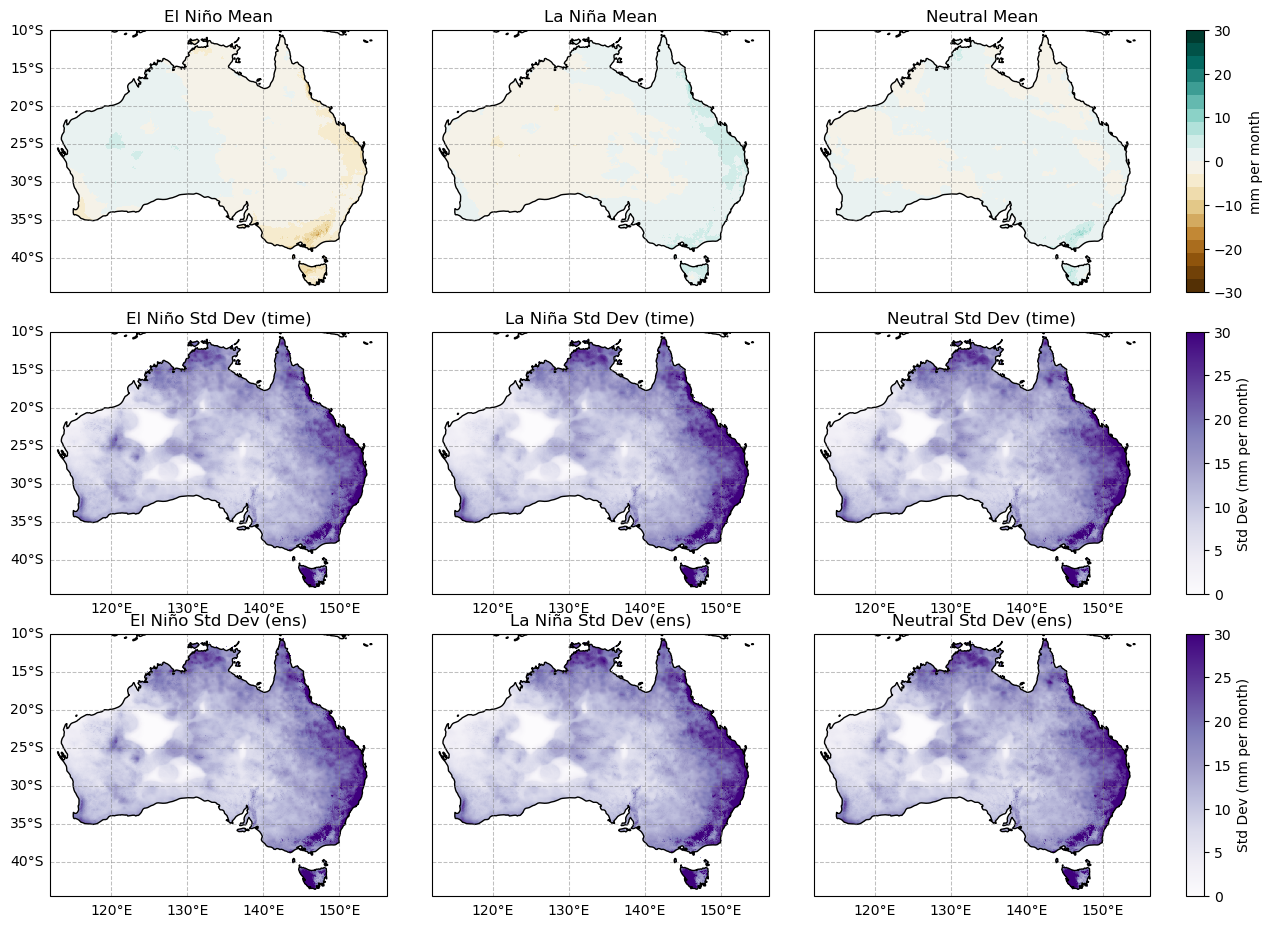

In [12]:
fig = plt.figure(figsize=(15, 11.25))  
gs = gridspec.GridSpec(3, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
cmap_pr = plt.get_cmap('BrBG', 20)

# Row 1: Mean Composites
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = comp_son_lag9_EN.mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño Mean')
ax = format_gridlines(ax, left_labels=True, bottom_labels=False) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = comp_son_lag9_LN.mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña Mean')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = comp_son_lag9_NN.mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral Mean')
ax = format_gridlines(ax) 

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

# Row 2: Standard Deviation Maps through time 
ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = comp_son_lag9_EN_std_time.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño Std Dev (time)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = comp_son_lag9_LN_std_time.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña Std Dev (time)')
ax = format_gridlines(ax, bottom_labels=True)

ax = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
im = comp_son_lag9_NN_std_time.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral Std Dev (time)')
ax = format_gridlines(ax, bottom_labels=True) 

# Second colorbar for std deviation
cax2 = plt.subplot(gs[1, 3])
cbar = plt.colorbar(im, cax2)
cbar.ax.set_ylabel('Std Dev (mm per month)');

# Row 3: Standard Deviation Maps ensemble
ax = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
im = comp_son_lag9_EN_std_ens.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño Std Dev (ens)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
im = comp_son_lag9_LN_std_ens.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña Std Dev (ens)')
ax = format_gridlines(ax, bottom_labels=True)

ax = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree())
im = comp_son_lag9_NN_std_ens.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral Std Dev (ens)')
ax = format_gridlines(ax, bottom_labels=True) 

# Second colorbar for std deviation
cax3 = plt.subplot(gs[2, 3])
cbar = plt.colorbar(im, cax3)
cbar.ax.set_ylabel('Std Dev (mm per month)');

In [13]:
# Quantiles for anomalies
quantiles_lag9 = anom_son_lag9.quantile([0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9], dim='year')

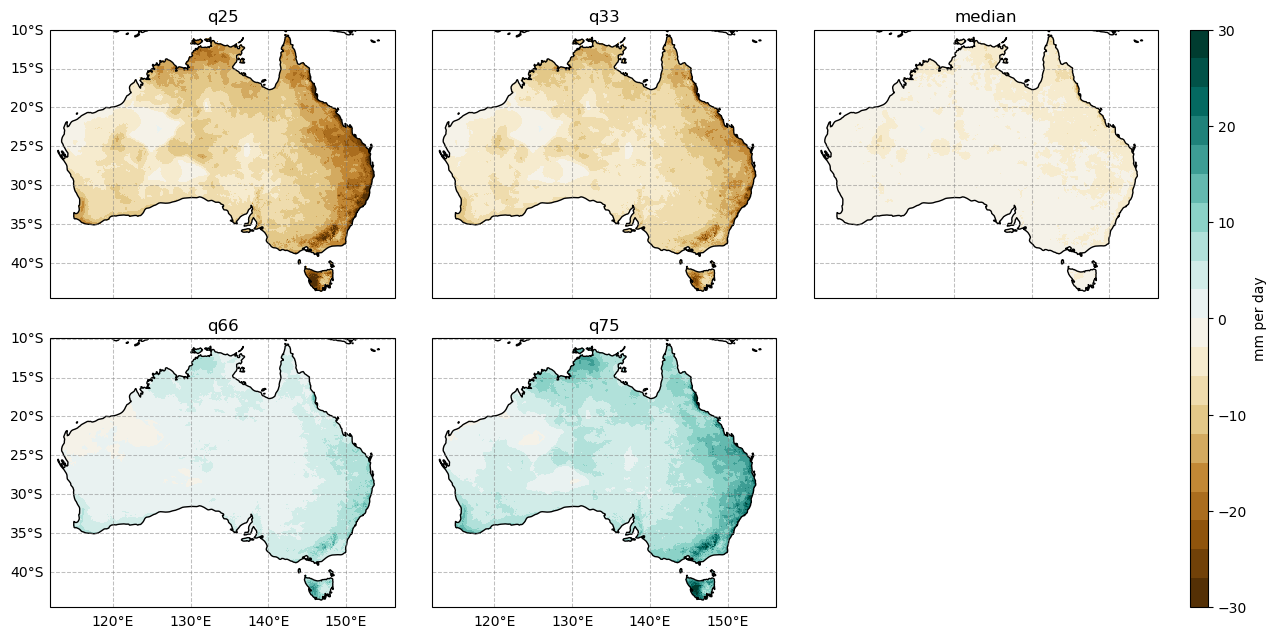

In [14]:
fig = plt.figure(figsize=(15, 7.5))  
gs = gridspec.GridSpec(2, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -30
vmax = 30

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = quantiles_lag9.sel(quantile=0.25).mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q25')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = quantiles_lag9.sel(quantile=0.33).mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q33')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = quantiles_lag9.sel(quantile=0.5).mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('median')
ax = format_gridlines(ax) 

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = quantiles_lag9.sel(quantile=0.66).mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q66')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = quantiles_lag9.sel(quantile=0.75).mean(dim='ensemble').plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q75')
ax = format_gridlines(ax, bottom_labels=True) 

cax = plt.subplot(gs[:, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per day');

#### Ensemble Average

In [15]:
anom_son_lag9_EN = anom_son_lag9_EN.mean(dim='ensemble')
anom_son_lag9_LN = anom_son_lag9_LN.mean(dim='ensemble') 
anom_son_lag9_NN = anom_son_lag9_NN.mean(dim='ensemble') 

#### FAR

In [16]:
def empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

def get_probability_exceed(cdf, data_values, threshold):
    """Returns probability P(X ≥ threshold) using the CDF."""
    idx = np.searchsorted(data_values, threshold, side='right') - 1
    idx = np.clip(idx, 0, len(data_values) - 1)  # Ensure valid index
    return 1 - cdf[..., idx] 

def get_probability_deficit(cdf, data_values, threshold):
    """Returns probability P(X ≤ threshold) using the CDF."""
    idx = np.searchsorted(data_values, threshold, side='right') - 1
    idx = np.clip(idx, 0, len(data_values) - 1)  # Ensure valid index
    return cdf[..., idx]

def spatial_probability_exceed(cdf, anom_data, threshold):
    
    P = xr.apply_ufunc(
        get_probability_exceed, cdf, anom_data, threshold,
        input_core_dims=[["year"], ["year"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

def spatial_probability_deficit(cdf, anom_data, threshold):
    
    P = xr.apply_ufunc(
        get_probability_deficit, cdf, anom_data, threshold,
        input_core_dims=[["year"], ["year"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

In [17]:
sorted_EN, cdf_EN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_lag9_EN, 
    input_core_dims=[["year"]],
    output_core_dims=[["year"], ["year"]], 
    vectorize=True,
    dask="parallelized"
)

sorted_LN, cdf_LN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_lag9_LN, 
    input_core_dims=[["year"]],
    output_core_dims=[["year"], ["year"]], 
    vectorize=True,
    dask="parallelized"
)

sorted_NN, cdf_NN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_lag9_NN, 
    input_core_dims=[["year"]],
    output_core_dims=[["year"], ["year"]], 
    vectorize=True,
    dask="parallelized"
)

In [18]:
quantiles_lag9 = quantiles_lag9.mean(dim='ensemble')

In [19]:
q10_rainfall = quantiles_lag9.sel(quantile=0.10)
q25_rainfall = quantiles_lag9.sel(quantile=0.25)
q33_rainfall = quantiles_lag9.sel(quantile=0.33)
median_rainfall = quantiles_lag9.sel(quantile=0.5)
q66_rainfall = quantiles_lag9.sel(quantile=0.66)
q75_rainfall = quantiles_lag9.sel(quantile=0.75)
q90_rainfall = quantiles_lag9.sel(quantile=0.90)

In [20]:
P_EN_10th = spatial_probability_deficit(cdf_EN, anom_son_lag9_EN, q10_rainfall)
P_NN_10th = spatial_probability_deficit(cdf_NN, anom_son_lag9_NN, q10_rainfall)

P_EN_25th = spatial_probability_deficit(cdf_EN, anom_son_lag9_EN, q25_rainfall)
P_NN_25th = spatial_probability_deficit(cdf_NN, anom_son_lag9_NN, q25_rainfall)

P_EN_33th = spatial_probability_deficit(cdf_EN, anom_son_lag9_EN, q33_rainfall)
P_NN_33th = spatial_probability_deficit(cdf_NN, anom_son_lag9_NN, q33_rainfall)

P_EN_median_below = spatial_probability_deficit(cdf_EN, anom_son_lag9_EN, median_rainfall)
P_NN_median_below = spatial_probability_deficit(cdf_NN, anom_son_lag9_NN, median_rainfall)

In [21]:
P_LN_median_above = spatial_probability_exceed(cdf_LN, anom_son_lag9_LN, median_rainfall)
P_NN_median_above = spatial_probability_exceed(cdf_NN, anom_son_lag9_NN, median_rainfall)

P_LN_66th = spatial_probability_exceed(cdf_LN, anom_son_lag9_LN, q66_rainfall)
P_NN_66th = spatial_probability_exceed(cdf_NN, anom_son_lag9_NN, q66_rainfall)

P_LN_75th = spatial_probability_exceed(cdf_LN, anom_son_lag9_LN, q75_rainfall)
P_NN_75th = spatial_probability_exceed(cdf_NN, anom_son_lag9_NN, q75_rainfall)

P_LN_90th = spatial_probability_exceed(cdf_LN, anom_son_lag9_LN, q90_rainfall)
P_NN_90th = spatial_probability_exceed(cdf_NN, anom_son_lag9_NN, q90_rainfall)

In [22]:
FAR_EN_10th = 1 - (P_NN_10th / P_EN_10th)
FAR_EN_25th = 1 - (P_NN_25th / P_EN_25th)
FAR_EN_33th = 1 - (P_NN_33th / P_EN_33th)
FAR_EN_med_below = 1 - (P_NN_median_below / P_EN_median_below)

In [23]:
FAR_LN_med_above = 1 - (P_NN_median_above / P_LN_median_above)
FAR_LN_66th = 1 - (P_NN_66th / P_LN_66th)
FAR_LN_75th = 1 - (P_NN_75th / P_LN_75th)
FAR_LN_90th = 1 - (P_NN_90th / P_LN_90th)

In [24]:
# FAR colorbar
colors = [
    "#0570b0", "#3690c0", "#74a9cf", "#a6bddb", "#d0d1e6",  
    "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c",
    "#fc6631", "#f03b20", "#e31a1c", "#bd0026", "#e7298a"
]

bounds_prob = np.concatenate([np.linspace(-1, 0, 6), np.linspace(0.1, 1, 10)]) 
cmap_prob = mcolors.ListedColormap(colors)
norm_prob = mcolors.BoundaryNorm(bounds_prob, cmap_prob.N)

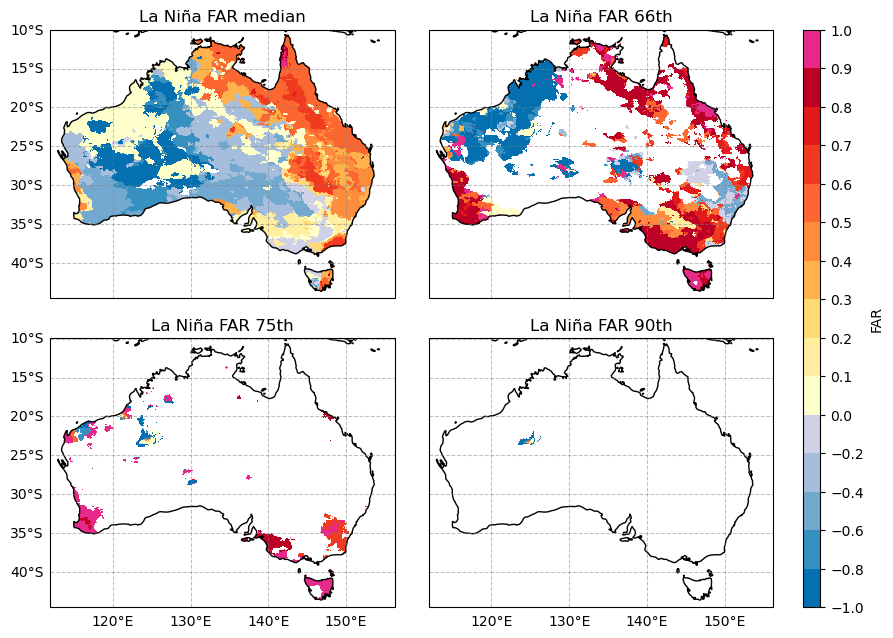

In [25]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_LN_med_above.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_LN_66th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_LN_75th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_LN_90th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');

In [26]:
# replace zero with nan - for some reason ocean is zero
FAR_EN_med_below = FAR_EN_med_below.where(FAR_EN_med_below != 0, np.nan)
FAR_EN_33th = FAR_EN_33th.where(FAR_EN_33th != 0, np.nan)
FAR_EN_25th = FAR_EN_25th.where(FAR_EN_25th != 0, np.nan)
FAR_EN_10th = FAR_EN_10th.where(FAR_EN_10th != 0, np.nan)

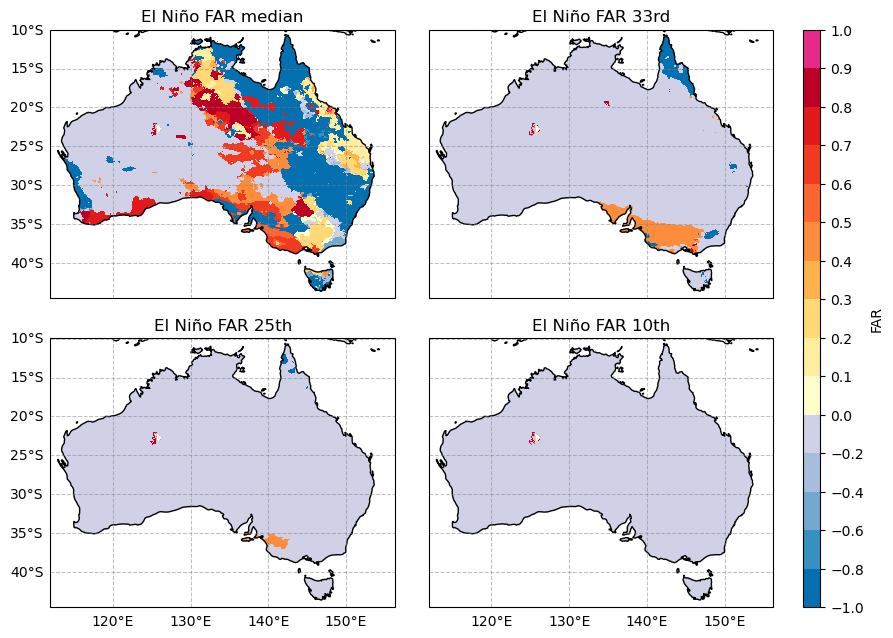

In [27]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_EN_med_below.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_EN_33th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 33rd')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_EN_25th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 25th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_EN_10th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 10th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');